In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file_path = '/content/drive/My Drive/Energy/data/test_data/daejeonsigungu2.xlsx'

df = pd.read_excel(file_path)
df.head()

,USEYM,SIGUNGUCD,CODENM,ELECUSEQTY,GASUSEQTY,CARBONQTY
0,201801,30110,대전광역시 동구,248720958,880930832,308042461
1,201801,30140,대전광역시 중구,318977062,1482086841,472565379
2,201801,30170,대전광역시 서구,773782567,2383248991,879713186
3,201801,30200,대전광역시 유성구,2217157991,2368181476,1539340692
4,201801,30230,대전광역시 대덕구,422027519,566858042,318546041


In [ ]:
df2 = df[['USEYM', 'ELECUSEQTY', 'SIGUNGUCD']]
df2

,USEYM,ELECUSEQTY,SIGUNGUCD
0,201801,248720958,30110
1,201801,318977062,30140
2,201801,773782567,30170
3,201801,2217157991,30200
4,201801,422027519,30230
...,...,...,...
330,202307,299092467,30110
331,202307,315225641,30140
332,202307,810750039,30170
333,202307,2488323432,30200


In [ ]:
import pandas as pd

# USEYM 열을 년월 형식으로 변환하고 인덱스로 설정
df2['USEYM'] = pd.to_datetime(df2['USEYM'], format='%Y%m')
df2.set_index('USEYM', inplace=True)

# 년, 월, 분기 정보를 새로운 열로 추가
df2['year'] = df2.index.year
df2['month'] = df2.index.month
df2['quarter'] = df2.index.quarter
df2['month_str'] = df2.index.strftime('%Y-%m')

df2


<ipython-input-11-fb186b117312>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['USEYM'] = pd.to_datetime(df2['USEYM'], format='%Y%m')
<ipython-input-11-fb186b117312>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year'] = df2.index.year
<ipython-input-11-fb186b117312>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,ELECUSEQTY,SIGUNGUCD,year,month,quarter,month_str
USEYM,,,,,,
2018-01-01,248720958,30110,2018,1,1,2018-01
2018-01-01,318977062,30140,2018,1,1,2018-01
2018-01-01,773782567,30170,2018,1,1,2018-01
2018-01-01,2217157991,30200,2018,1,1,2018-01
2018-01-01,422027519,30230,2018,1,1,2018-01
...,...,...,...,...,...,...
2023-07-01,299092467,30110,2023,7,3,2023-07
2023-07-01,315225641,30140,2023,7,3,2023-07
2023-07-01,810750039,30170,2023,7,3,2023-07


# 최종 코드

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np

# 데이터를 월별로 집계
monthly_agg = df2.groupby(['USEYM', 'SIGUNGUCD']).agg({'GASUSEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'}).reset_index()

# 모델 훈련을 위한 특성과 타겟
FEATURES = ['year', 'month', 'quarter']
TARGET = 'GASUSEQTY'

# 훈련 데이터와 테스트 데이터 분할
train_data = monthly_agg.loc[monthly_agg['USEYM'] <= '2022-12-31']
test_data = monthly_agg.loc[monthly_agg['USEYM'] >= '2023-01-01']

# 각 구별로 모델 훈련 및 예측
predictions_df = pd.DataFrame()

for sigungucd in monthly_agg['SIGUNGUCD'].unique():
    train_subset = train_data[train_data['SIGUNGUCD'] == sigungucd]
    test_subset = test_data[test_data['SIGUNGUCD'] == sigungucd]

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
    model.fit(train_subset[FEATURES], train_subset[TARGET])

    # 8월 예측
    future_dates = pd.date_range(start='2023-08-01', end='2023-12-31', freq='MS')
    future_data = pd.DataFrame(index=future_dates)
    future_data['year'] = future_data.index.year
    future_data['month'] = future_data.index.month
    future_data['quarter'] = future_data.index.quarter

    predictions = model.predict(future_data[FEATURES])
    future_data['prediction'] = predictions

    selected_building_data = future_data.copy()
    selected_building_data['SIGUNGUCD'] = sigungucd
    selected_building_data = selected_building_data[['year', 'month', 'quarter', 'SIGUNGUCD', 'prediction']]
    predictions_df = pd.concat([predictions_df, selected_building_data])

# 결과 출력
print(predictions_df)


            year  month  quarter  SIGUNGUCD    prediction
2023-08-01  2023      8        3      30110  1.502179e+08
2023-09-01  2023      9        3      30110  1.339154e+08
2023-10-01  2023     10        4      30110  1.449417e+08
2023-11-01  2023     11        4      30110  3.263184e+08
2023-12-01  2023     12        4      30110  5.449375e+08
2023-08-01  2023      8        3      30140  1.839681e+08
2023-09-01  2023      9        3      30140  1.773262e+08
2023-10-01  2023     10        4      30140  1.839225e+08
2023-11-01  2023     11        4      30140  4.973633e+08
2023-12-01  2023     12        4      30140  8.159196e+08
2023-08-01  2023      8        3      30170  3.671897e+08
2023-09-01  2023      9        3      30170  3.483808e+08
2023-10-01  2023     10        4      30170  3.505821e+08
2023-11-01  2023     11        4      30170  7.983146e+08
2023-12-01  2023     12        4      30170  1.253460e+09
2023-08-01  2023      8        3      30200  9.755744e+08
2023-09-01  20

# 성능평가

In [ ]:
from sklearn.metrics import r2_score

def calculate_smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# 데이터를 월별로 집계
monthly_agg = df2.groupby(['USEYM', 'SIGUNGUCD']).agg({'ELECUSEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'}).reset_index()

# 모델 훈련을 위한 특성과 타겟
FEATURES = ['year', 'month', 'quarter']
TARGET = 'ELECUSEQTY'

# 훈련 데이터와 테스트 데이터 분할
train_data = monthly_agg.loc[monthly_agg['USEYM'] <= '2022-12-31']
test_data = monthly_agg.loc[monthly_agg['USEYM'] >= '2023-01-01']

# 결과를 저장할 데이터프레임
results_df = pd.DataFrame(columns=['SIGUNGUCD', 'SMAPE', 'R2'])

for sigungucd in monthly_agg['SIGUNGUCD'].unique():
    train_subset = train_data[train_data['SIGUNGUCD'] == sigungucd]
    test_subset = test_data[test_data['SIGUNGUCD'] == sigungucd]

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
    model.fit(train_subset[FEATURES], train_subset[TARGET])

    # 테스트 데이터에 대한 예측
    y_true = test_subset[TARGET].values
    y_pred = model.predict(test_subset[FEATURES])

    # SMAPE와 R^2 계산
    smape = calculate_smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # 결과 저장
    results_df = results_df.append({'SIGUNGUCD': sigungucd, 'SMAPE': smape, 'R2': r2}, ignore_index=True)

# 시군구별 SMAPE와 R^2 출력
print(results_df)


<ipython-input-12-576bb6dc1b7c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'SIGUNGUCD': sigungucd, 'SMAPE': smape, 'R2': r2}, ignore_index=True)
<ipython-input-12-576bb6dc1b7c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'SIGUNGUCD': sigungucd, 'SMAPE': smape, 'R2': r2}, ignore_index=True)
<ipython-input-12-576bb6dc1b7c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'SIGUNGUCD': sigungucd, 'SMAPE': smape, 'R2': r2}, ignore_index=True)
<ipython-input-12-576bb6dc1b7c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df

   SIGUNGUCD      SMAPE         R2
0    30110.0  19.243871  -2.874528
1    30140.0   3.834299   0.690043
2    30170.0   2.122881   0.866611
3    30200.0   2.341403   0.795273
4    30230.0  33.704662 -13.895166


<ipython-input-12-576bb6dc1b7c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'SIGUNGUCD': sigungucd, 'SMAPE': smape, 'R2': r2}, ignore_index=True)


In [ ]:
predictions_df

,year,month,quarter,SIGUNGUCD,prediction
2023-08-01,2023,8,3,30110,1.502179e+08
2023-09-01,2023,9,3,30110,1.339154e+08
2023-10-01,2023,10,4,30110,1.449417e+08
2023-11-01,2023,11,4,30110,3.263184e+08
2023-12-01,2023,12,4,30110,5.449375e+08
2023-08-01,2023,8,3,30140,1.839681e+08
2023-09-01,2023,9,3,30140,1.773262e+08
2023-10-01,2023,10,4,30140,1.839225e+08
2023-11-01,2023,11,4,30140,4.973633e+08
2023-12-01,2023,12,4,30140,8.159196e+08


In [ ]:
predictions_df['USEYM'] = predictions_df['year'].astype(str) + predictions_df['month'].astype(str).str.zfill(2)
predictions_df

,year,month,quarter,SIGUNGUCD,prediction,USEYM
2023-08-01,2023,8,3,30110,1.502179e+08,202308
2023-09-01,2023,9,3,30110,1.339154e+08,202309
2023-10-01,2023,10,4,30110,1.449417e+08,202310
2023-11-01,2023,11,4,30110,3.263184e+08,202311
2023-12-01,2023,12,4,30110,5.449375e+08,202312
2023-08-01,2023,8,3,30140,1.839681e+08,202308
2023-09-01,2023,9,3,30140,1.773262e+08,202309
2023-10-01,2023,10,4,30140,1.839225e+08,202310
2023-11-01,2023,11,4,30140,4.973633e+08,202311
2023-12-01,2023,12,4,30140,8.159196e+08,202312


In [ ]:
predictions_df.rename(columns={'prediction': 'USEQTY'}, inplace=True)
predictions_df

,year,month,quarter,SIGUNGUCD,USEQTY,USEYM
2023-08-01,2023,8,3,30110,1.502179e+08,202308
2023-09-01,2023,9,3,30110,1.339154e+08,202309
2023-10-01,2023,10,4,30110,1.449417e+08,202310
2023-11-01,2023,11,4,30110,3.263184e+08,202311
2023-12-01,2023,12,4,30110,5.449375e+08,202312
2023-08-01,2023,8,3,30140,1.839681e+08,202308
2023-09-01,2023,9,3,30140,1.773262e+08,202309
2023-10-01,2023,10,4,30140,1.839225e+08,202310
2023-11-01,2023,11,4,30140,4.973633e+08,202311
2023-12-01,2023,12,4,30140,8.159196e+08,202312


In [ ]:
predictions_df = predictions_df[['SIGUNGUCD', 'USEQTY', 'USEYM']]


In [ ]:
predictions_df

,SIGUNGUCD,USEQTY,USEYM
2023-08-01,30110,1.502179e+08,202308
2023-09-01,30110,1.339154e+08,202309
2023-10-01,30110,1.449417e+08,202310
2023-11-01,30110,3.263184e+08,202311
2023-12-01,30110,5.449375e+08,202312
2023-08-01,30140,1.839681e+08,202308
2023-09-01,30140,1.773262e+08,202309
2023-10-01,30140,1.839225e+08,202310
2023-11-01,30140,4.973633e+08,202311
2023-12-01,30140,8.159196e+08,202312


<ipython-input-8-e9738a909a50>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = model.predict(test_data[FEATURES])


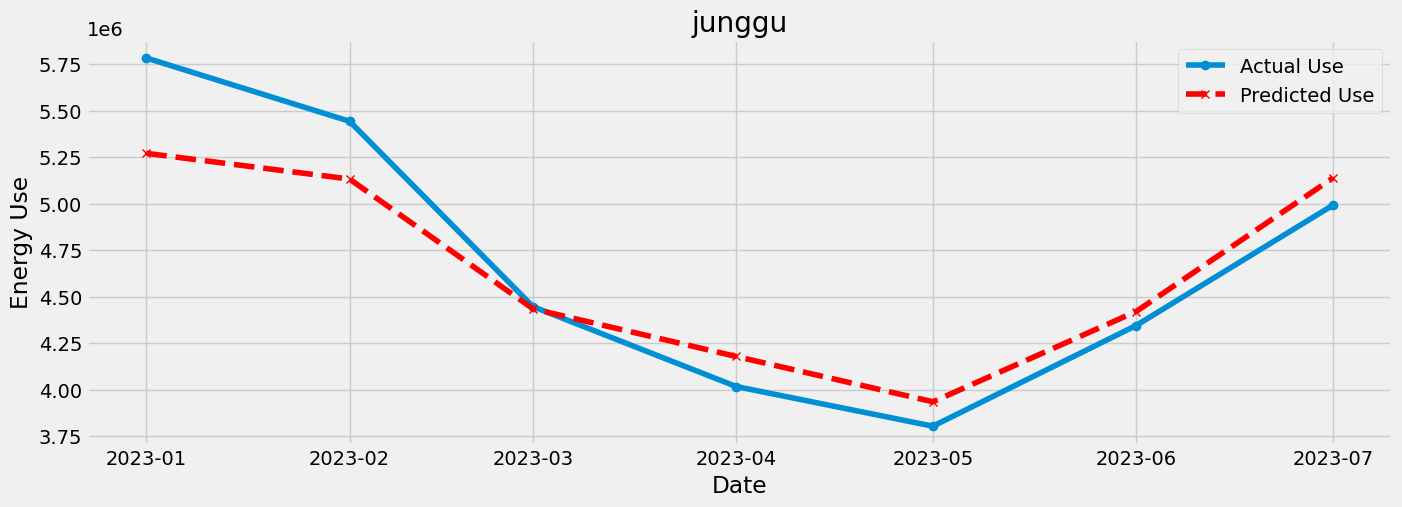

RMSE: 247696.96
MAE: 192667.18
R^2: 0.87
sMAPE: 0.04


In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

monthly_agg = df2.groupby(['USEYM', 'SIGUNGUCD']).agg({'USEQTY':'sum', 'year':'first', 'month':'first', 'quarter':'first'}).reset_index()

# 모델 훈련을 위한 특성과 타겟
FEATURES = ['year', 'month', 'quarter']
TARGET = 'USEQTY'

# 대덕구
data_30230 = monthly_agg[monthly_agg['SIGUNGUCD'] == 30140]

train_data = data_30230.loc[(data_30230['USEYM'] >= '2018-01-01') & (data_30230['USEYM'] <= '2022-12-31')]
test_data = data_30230.loc[(data_30230['USEYM'] >= '2023-01-01') & (data_30230['USEYM'] <= '2023-07-31')]


# 모델 훈련
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, objective='reg:squarederror', random_state=42)
model.fit(train_data[FEATURES], train_data[TARGET])

# 월별 예측을 수행
test_data['prediction'] = model.predict(test_data[FEATURES])

plt.figure(figsize=(15, 5))
plt.plot(test_data['USEYM'], test_data[TARGET], label='Actual Use', marker='o', linestyle='-')
plt.plot(test_data['USEYM'], test_data['prediction'], label='Predicted Use', marker='x', linestyle='--', color='red')
plt.title('junggu')
plt.xlabel('Date')
plt.ylabel('Energy Use')
plt.legend()
plt.show()



# 성능평가
actual_values = test_data[TARGET].dropna()
predicted_values = test_data['prediction'].loc[actual_values.index]

rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae_value = np.abs(actual_values - predicted_values).mean()
r2_value = r2_score(actual_values, predicted_values)
smape_value = (np.abs(actual_values - predicted_values) / ((np.abs(actual_values) + np.abs(predicted_values)) / 2)).mean()

print(f'RMSE: {rmse_value:.2f}')
print(f'MAE: {mae_value:.2f}')
print(f'R^2: {r2_value:.2f}')
print(f'sMAPE: {smape_value:.2f}')


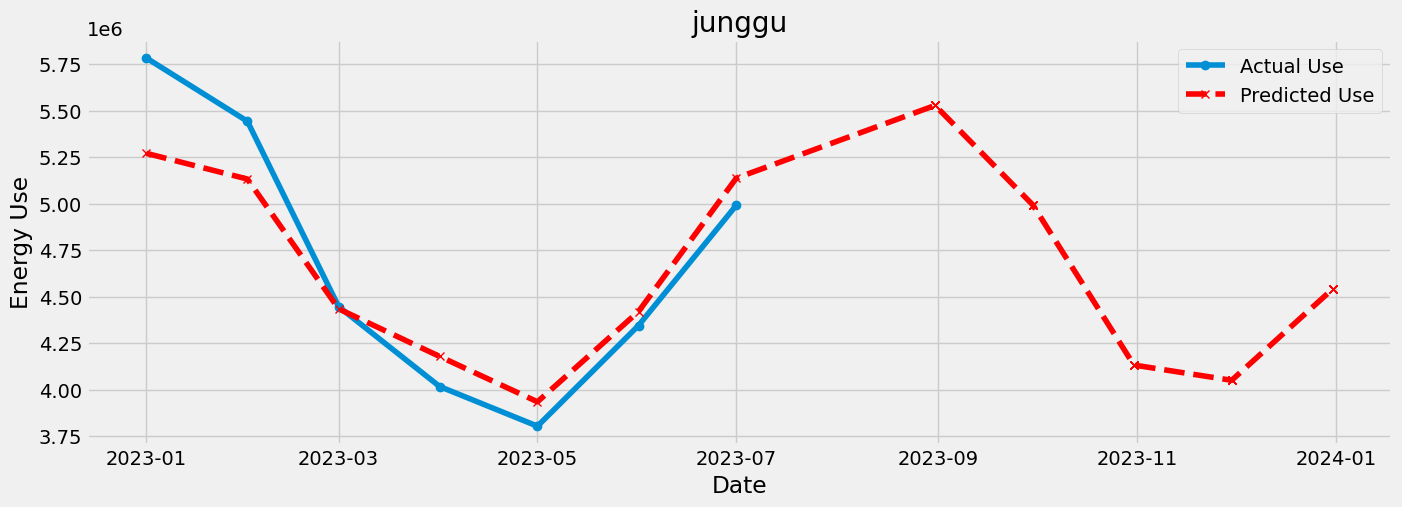

RMSE: 247696.96
MAE: 192667.18
R^2: 0.87
sMAPE: 0.04


In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Extend predictions to include August to December
extended_dates = pd.date_range(start='2023-08-01', end='2023-12-31', freq='M')
extended_data = pd.DataFrame({'USEYM': extended_dates})
extended_data['year'] = extended_data['USEYM'].dt.year
extended_data['month'] = extended_data['USEYM'].dt.month
extended_data['quarter'] = (extended_data['month'] - 1) // 3 + 1

# Use your trained model to predict for the extended period
extended_data['prediction'] = model.predict(extended_data[FEATURES])

# Concatenate the extended data with your test data
combined_data = pd.concat([test_data, extended_data], ignore_index=True)

# Sort the combined data by date
combined_data = combined_data.sort_values(by='USEYM')

# Plot the updated combined_data DataFrame
plt.figure(figsize=(15, 5))
plt.plot(combined_data['USEYM'], combined_data[TARGET], label='Actual Use', marker='o', linestyle='-')
plt.plot(combined_data['USEYM'], combined_data['prediction'], label='Predicted Use', marker='x', linestyle='--', color='red')
plt.title('junggu')
plt.xlabel('Date')
plt.ylabel('Energy Use')
plt.legend()
plt.show()

# Calculate performance metrics for the entire test period (including August to December)
actual_values = combined_data[TARGET].dropna()
predicted_values = combined_data['prediction'].loc[actual_values.index]

rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae_value = np.abs(actual_values - predicted_values).mean()
r2_value = r2_score(actual_values, predicted_values)
smape_value = (np.abs(actual_values - predicted_values) / ((np.abs(actual_values) + np.abs(predicted_values)) / 2)).mean()

print(f'RMSE: {rmse_value:.2f}')
print(f'MAE: {mae_value:.2f}')
print(f'R^2: {r2_value:.2f}')
print(f'sMAPE: {smape_value:.2f}')
